In [3]:
!pip install -r requirements.txt

  Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl.metadata (1.5 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached optuna-4.2.1-py3-none-any.whl (383 kB)
Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl (11.5 MB)
Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl (11.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using c


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install xgboost
!pip install catboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

asttokens==3.0.0
colorama==0.4.6
comm==0.2.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
executing==2.2.0
fonttools==4.57.0
graphviz==0.20.3
greenlet==3.2.0
ipykernel==6.29.5
ipython==9.1.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
MarkupSafe==3.0.2
matplotlib-inline==0.1.7
narwhals==1.35.0
nest-asyncio==1.6.0
numpy==2.2.4
packaging==24.2
parso==0.8.4
pillow==11.2.1
platformdirs==4.3.7
plotly==6.0.1
prompt_toolkit==3.0.51
psutil==7.0.0
pure_eval==0.2.3
Pygments==2.19.1
pyparsing==3.2.3
python-dateutil==2.9.0.post0
pytz==2025.2
pywin32==310
PyYAML==6.0.2
pyzmq==26.4.0
scipy==1.15.2
six==1.17.0
SQLAlchemy==2.0.40
stack-data==0.6.3
threadpoolctl==3.6.0
tornado==6.4.2
tqdm==4.67.1
traitlets==5.14.3
typing_extensions==4.13.2
tzdata==2025.2
wcwidth==0.2.13


In [272]:
df_1 = pd.read_json('DATASET_FINAL.json')

df = df_1.copy()
# df = df[~df['fr_title'].isin(title_error_list)]


In [274]:
# Groupement des acteurs 1, 2, 3 , scénaristes, réalisateurs, et distributeurs qui font plus de 500k entrées 
# + ajout d'un groupe "mid" entre 250k et 500k

# Acteur 1
df_actor_1 = df.groupby('actor_1')['weekly_entrances'].mean().reset_index()
df_actor_1_mid = df_actor_1[(df_actor_1['weekly_entrances'] < 500001) & (df_actor_1['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_1 = df_actor_1[df_actor_1['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 2
df_actor_2 = df.groupby('actor_2')['weekly_entrances'].mean().reset_index()
df_actor_2_mid = df_actor_2[(df_actor_2['weekly_entrances'] < 500001) & (df_actor_2['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_2 = df_actor_2[df_actor_2['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 3
df_actor_3 = df.groupby('actor_3')['weekly_entrances'].mean().reset_index()
df_actor_3_mid = df_actor_3[(df_actor_3['weekly_entrances'] < 500001) & (df_actor_3['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_3 = df_actor_3[df_actor_3['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Réalisateurs
df_directors = df.groupby('directors')['weekly_entrances'].mean().reset_index()
df_directors_mid = df_directors[(df_directors['weekly_entrances'] < 500001) & (df_directors['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_directors = df_directors[df_directors['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Scénaristes
df_writer = df.groupby('writer')['weekly_entrances'].mean().reset_index()
df_writer_mid = df_writer[(df_writer['weekly_entrances'] < 500001) & (df_writer['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_writer = df_writer[df_writer['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Distributeurs
df_distribution = df.groupby('distribution')['weekly_entrances'].mean().reset_index()
df_distribution_mid = df_distribution[(df_distribution['weekly_entrances'] < 500001) & (df_distribution['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_distribution = df_distribution[df_distribution['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)


In [275]:
# Création des colonnes "top" et "top_mid" pour les différents groupes

df['top_actor_1'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1['actor_1'].to_list() else 0)
df['top_actor_1_mid'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1_mid['actor_1'].to_list() else 0)

df['top_actor_2'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2['actor_2'].to_list() else 0)
df['top_actor_2_mid'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2_mid['actor_2'].to_list() else 0)

df['top_actor_3'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3['actor_3'].to_list() else 0)
df['top_actor_3_mid'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3_mid['actor_3'].to_list() else 0)

df['top_director'] = df['directors'].apply(lambda x: 1 if x in df_directors['directors'].to_list() else 0)
df['top_director_mid'] = df['directors'].apply(lambda x: 1 if x in df_directors_mid['directors'].to_list() else 0)

df['top_writer'] = df['writer'].apply(lambda x: 1 if x in df_writer['writer'].to_list() else 0)
df['top_writer_mid'] = df['writer'].apply(lambda x: 1 if x in df_writer_mid['writer'].to_list() else 0)

df['top_distribution'] = df['distribution'].apply(lambda x: 1 if x in df_distribution['distribution'].to_list() else 0)
df['top_distribution_mid'] = df['distribution'].apply(lambda x: 1 if x in df_distribution_mid['distribution'].to_list() else 0)


In [276]:
# Définition des bornes de classification (en dollars)
bins = [0, 500_000, 5_000_000, 30_000_000, 100_000_000, float('inf')]

# Noms des catégories correspondantes
labels = [
    "Ultra low budget",
    "Low budget",
    "Mid budget",
    "High budget",
    "Blockbuster / AAA"
]

# Création de la nouvelle colonne "budget_category"
df['budget_category'] = pd.cut(df['budget'], bins=bins, labels=labels, right=False)

# Affichage du résultat
df.head()

,fr_title,released_year,directors,writer,distribution,country,budget,category,released_date,classification,...,top_actor_2_mid,top_actor_3,top_actor_3_mid,top_director,top_director_mid,top_writer,top_writer_mid,top_distribution,top_distribution_mid,budget_category
0,La Ch’tite famille,2018,Dany Boon,Dany Boon,Pathé Films,France,27800000,Comédie,28/02/2018,Tout public,...,1,0,1,1,0,1,0,0,1,Mid budget
1,Rien à déclarer,2011,Dany Boon,Dany Boon,Pathé Films,France,24434009,Comédie,02/02/2011,Interdit - 10 ans,...,1,1,0,1,0,1,0,0,1,Mid budget
2,Avatar,2009,James Cameron,James Cameron,The Walt Disney Company France,Etats-Unis,315000000,Science Fiction,16/12/2009,Tout public,...,0,1,0,1,0,1,0,1,0,Blockbuster / AAA
3,Avengers: Infinity War,2018,- Russo (brothers),Christopher Markus,The Walt Disney Company France,Etats-Unis,295000000,Comicbook,25/04/2018,Tout public,...,0,1,0,1,0,1,0,1,0,Blockbuster / AAA
4,Harry Potter et les reliques de la mort - part...,2010,David Yates,Joanne Kathleen Rowling,Warner Bros.,Etats-Unis,125000000,Fantasy,24/11/2010,Tout public,...,0,1,0,1,0,1,0,1,0,Blockbuster / AAA


In [280]:
features_of_interest = [
    # "actor_1",
    # "actor_2",
    # 'actor_3',
    # "directors",
    #  "writer",
    # "distribution",
    # "fr_title",
    'released_year',
    "country",
    #"budget",
    'category',
    'classification',
    'duration_minutes', 
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'budget_category'
]


numerical_column = [
    #"budget",
    'released_year',
    "duration_minutes",
]


ordinal_column = [
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'top_distribution',
]

categorical_column = [
        # "actor_1",
        # "actor_2",
        # "actor_3",
        # "directors",
        # "writer",
        # "distribution",
    # "fr_title",
    "country",
    'category',
    'classification',
    'budget_category'

]

#
target_name = "weekly_entrances"
data, target, numerical_data,categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[categorical_column]
)


In [281]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.9, random_state=42, stratify = df['budget_category'])

In [249]:
X_train

,fr_title,released_year,country,category,classification,duration_minutes,top_actor_1,top_actor_2,top_actor_3,top_director,top_writer,top_distribution,top_actor_1_mid,top_actor_2_mid,top_actor_3_mid,top_director_mid,top_writer_mid,top_distribution_mid
2470,Père et fille,2004,Etats-Unis,Comédie,Interdit - 10 ans,103,0,0,1,0,0,0,0,1,0,0,0,0
4062,La Bande à Baader,2008,Allemagne,Drame,Tout public,145,0,0,0,0,0,0,0,0,0,0,0,0
5899,The Box,2009,Etats-Unis,Thriller,Tout public,115,1,0,0,0,0,0,0,1,0,0,0,0
4030,Le Quatrième mur,2025,France,Drame,Tout public,116,0,0,0,0,0,0,1,0,0,0,0,0
3540,L'Etrangère,2011,Allemagne,Drame,Tout public,119,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,La Marche,2013,France,Comédie dramatique,Tout public,125,0,1,0,0,0,0,0,0,0,0,0,1
4451,Changement d'adresse,2006,France,Comédie,Tout public,85,0,0,0,0,0,0,0,0,0,0,0,0
5941,Moonfall,2022,Etats-Unis,Science Fiction,Tout public,120,1,0,0,0,0,0,0,1,0,1,0,0
433,Hannibal Lecter : les origines du mal,2007,Grande-Bretagne,Thriller,Interdit - 12 ans,117,0,0,0,0,0,0,1,0,1,1,1,0


In [283]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("numeric", RobustScaler(), numerical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column)
    ],
    remainder="passthrough",
)

# catboost_model = make_pipeline(preprocessor,CatBoostRegressor(depth=4,iterations=300,l2_leaf_reg=1,learning_rate=0.07))
catboost_model = make_pipeline(preprocessor,CatBoostRegressor())
catboost_model.fit(X_train,y_train)

# Prédictions sur le test
y_pred = catboost_model.predict(X_test)

# Calcul des métriques
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
errors = y_pred - y_test
sum_errors = np.sum(errors)
mean_errors = np.mean(errors)
print(f"✅ RMSE (test) Catboost: {rmse:.4f}")
print(f"✅ MAPE (test) Catboost: {mape:.4f}")
print(f"🔥 Somme des erreurs: {sum_errors:.4f}")
print(f"🔥 moyenne des erreurs: {mean_errors:.4f}")

Learning rate set to 0.055066
0:	learn: 337249.6242720	total: 3.26ms	remaining: 3.26s
1:	learn: 325945.6941865	total: 6.1ms	remaining: 3.04s
2:	learn: 315311.0680799	total: 9.29ms	remaining: 3.09s
3:	learn: 304917.3155748	total: 14.2ms	remaining: 3.54s
4:	learn: 296022.0992323	total: 17.2ms	remaining: 3.42s
5:	learn: 286718.2862161	total: 21.1ms	remaining: 3.5s
6:	learn: 278807.2352431	total: 24ms	remaining: 3.4s
7:	learn: 271373.5054515	total: 28.3ms	remaining: 3.51s
8:	learn: 263912.4179213	total: 32ms	remaining: 3.52s
9:	learn: 257264.0807329	total: 35.3ms	remaining: 3.49s
10:	learn: 250752.9657856	total: 38.6ms	remaining: 3.47s
11:	learn: 245008.1836985	total: 43.7ms	remaining: 3.6s
12:	learn: 240135.6060478	total: 47ms	remaining: 3.57s
13:	learn: 234970.2045599	total: 51ms	remaining: 3.59s
14:	learn: 230591.5744454	total: 53.9ms	remaining: 3.54s
15:	learn: 226382.2115424	total: 57.7ms	remaining: 3.55s
16:	learn: 221860.2099150	total: 62.4ms	remaining: 3.61s
17:	learn: 218453.80955

In [ ]:
# Créer un DataFrame avec les erreurs et le titre (fr_title) du test

y_pred_train = catboost_model.predict(X_train)
errors_test = y_pred_train - y_train
df_title_total = pd.concat([X_test['fr_title'], X_train['fr_title']])
# print(df_title_total)
total_error = (list(errors_test)+ list(errors))


df_title_modele = pd.DataFrame({
    'fr_title': df_title_total.values,
    'error': total_error
})


title_error = df_title_modele[df_title_modele['error']> abs(2000)]

title_error_list = title_error['fr_title'].to_list()

title_error_list

['Le goût des autres',
 'Hitman & Bodyguard',
 'La Cloche a sonné',
 'Nuits de terreur',
 'Marion',
 'Fortress',
 'Lou ! Journal infime',
 "Le Voyage d'Arlo",
 "Harry Potter et le Prisonnier d'Azkaban",
 "Goal ! : naissance d'un prodige",
 'La Légende de Zorro',
 'Pension complète',
 'Un Beau Soleil Intérieur',
 'Miraculous - le film',
 'N’avoue jamais',
 'Cloclo',
 'Belphégor, le fantôme du Louvre',
 'Lucky Strike',
 'Fréquence interdite',
 'Le Pharmacien de garde',
 'Esprits rebelles',
 'La Dame en Noir 2 : L’Ange de la Mort',
 'Les Grands Ducs',
 'Don Jon',
 'Horizon : une saga américaine Chapitre 1',
 'Bad luck !',
 'Le Quatrième mur',
 'Elser, Un Héros ordinaire',
 'Cinquante Nuances de Grey',
 'Lingaa',
 'La Maison au bout de la rue',
 'Le Voyage aux Pyrénées',
 "L'Orphelinat",
 'Rendez-vous Chez Les Malawas',
 'Jason X',
 'Bridget Jones : folle de lui',
 'Guy',
 'Rémi Sans Famille',
 "L'Incroyable Voyage à San Francisco",
 'Action ou vérité',
 'Wonder',
 'Tu ne tueras point',
 '

In [137]:
len(X_test)

726

In [118]:
import pandas as pd
import numpy as np

# Étape 1 : Extraire le modèle CatBoost et le préprocessor depuis le pipeline
fitted_preprocessor = catboost_model.named_steps["columntransformer"]
fitted_model = catboost_model.named_steps["catboostregressor"]

# Étape 2 : Récupérer tous les noms de features après transformation
# - Categorical (OneHotEncoder)
cat_feat_names = fitted_preprocessor.named_transformers_["categorical"]\
    .get_feature_names_out(categorical_column)

# - Numeric (RobustScaler)
num_feat_names = numerical_column

# - Ordinal (OrdinalEncoder)
ord_feat_names = ordinal_column

# - Autres (remainder passthrough)
# Ici on a rien en plus, donc on concatène
feature_names = np.concatenate([cat_feat_names, num_feat_names, ord_feat_names])

# Étape 3 : Récupérer les importances du modèle
importances = fitted_model.feature_importances_

# Étape 4 : Créer un DataFrame trié avec noms + importances
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("📊 Feature Importances (top 30) :")
print(feat_imp_df.head(30))

# Étape 5 : Somme des valeurs d'origine pour chaque colonne d'intérêt
print("\n🧮 Sommes des valeurs par feature (dans les données brutes) :")

for col in numerical_column + ordinal_column:
    print(f"{col:25}: {df[col].sum():,.0f}")


📊 Feature Importances (top 30) :
                              Feature  Importance
108                        top_writer   23.063485
106                       top_actor_3   12.032232
107                      top_director   11.731868
103                  duration_minutes    8.133837
105                       top_actor_2    7.143783
104                       top_actor_1    7.002018
113                    top_writer_mid    4.770230
112                  top_director_mid    3.601144
111                   top_actor_3_mid    3.312552
102                     released_year    2.371011
110                   top_actor_2_mid    2.286685
26                     country_France    2.283858
109                   top_actor_1_mid    2.237288
115                  top_distribution    1.980592
83                   category_Fantasy    1.695601
78                   category_Comédie    0.993792
114              top_distribution_mid    0.992450
99    classification_Interdit - 6 ans    0.631059
77               

In [113]:
items_list = feat_imp_df['Feature'].unique()
to_remove = ['budget', 'top_writer', 'duration_minutes', 'top_actor_3',
             'top_actor_1', 'top_actor_2', 'top_director']

items_list = [item for item in items_list if item not in to_remove]

for category in categorical_column:

    list_sum = 0
    to_drop = []

    for cat in items_list:
        if category in cat:
            list_sum += feat_imp_df.loc[feat_imp_df['Feature'] == cat, 'Importance'].values[0]
            to_drop.append(cat)

    feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(to_drop)]

    new_row = pd.DataFrame([{'Feature': category, 'Importance': list_sum}])
    feat_imp_df = pd.concat([feat_imp_df, new_row], axis=0, ignore_index=True)

    print(f'la somme de {category} est de {list_sum}')

# Affichage final
feat_imp_df


la somme de country est de 2.6847011018503983
la somme de category est de 5.316531186600769
la somme de classification est de 1.981953510124529


,Feature,Importance
0,top_writer,25.769208
1,top_actor_3,13.259146
2,top_director,8.305425
3,top_actor_1,7.475738
4,duration_minutes,6.990208
5,top_actor_2,6.942988
6,top_writer_mid,5.282871
7,top_actor_3_mid,2.920425
8,released_year,2.871165
9,top_director_mid,2.804325


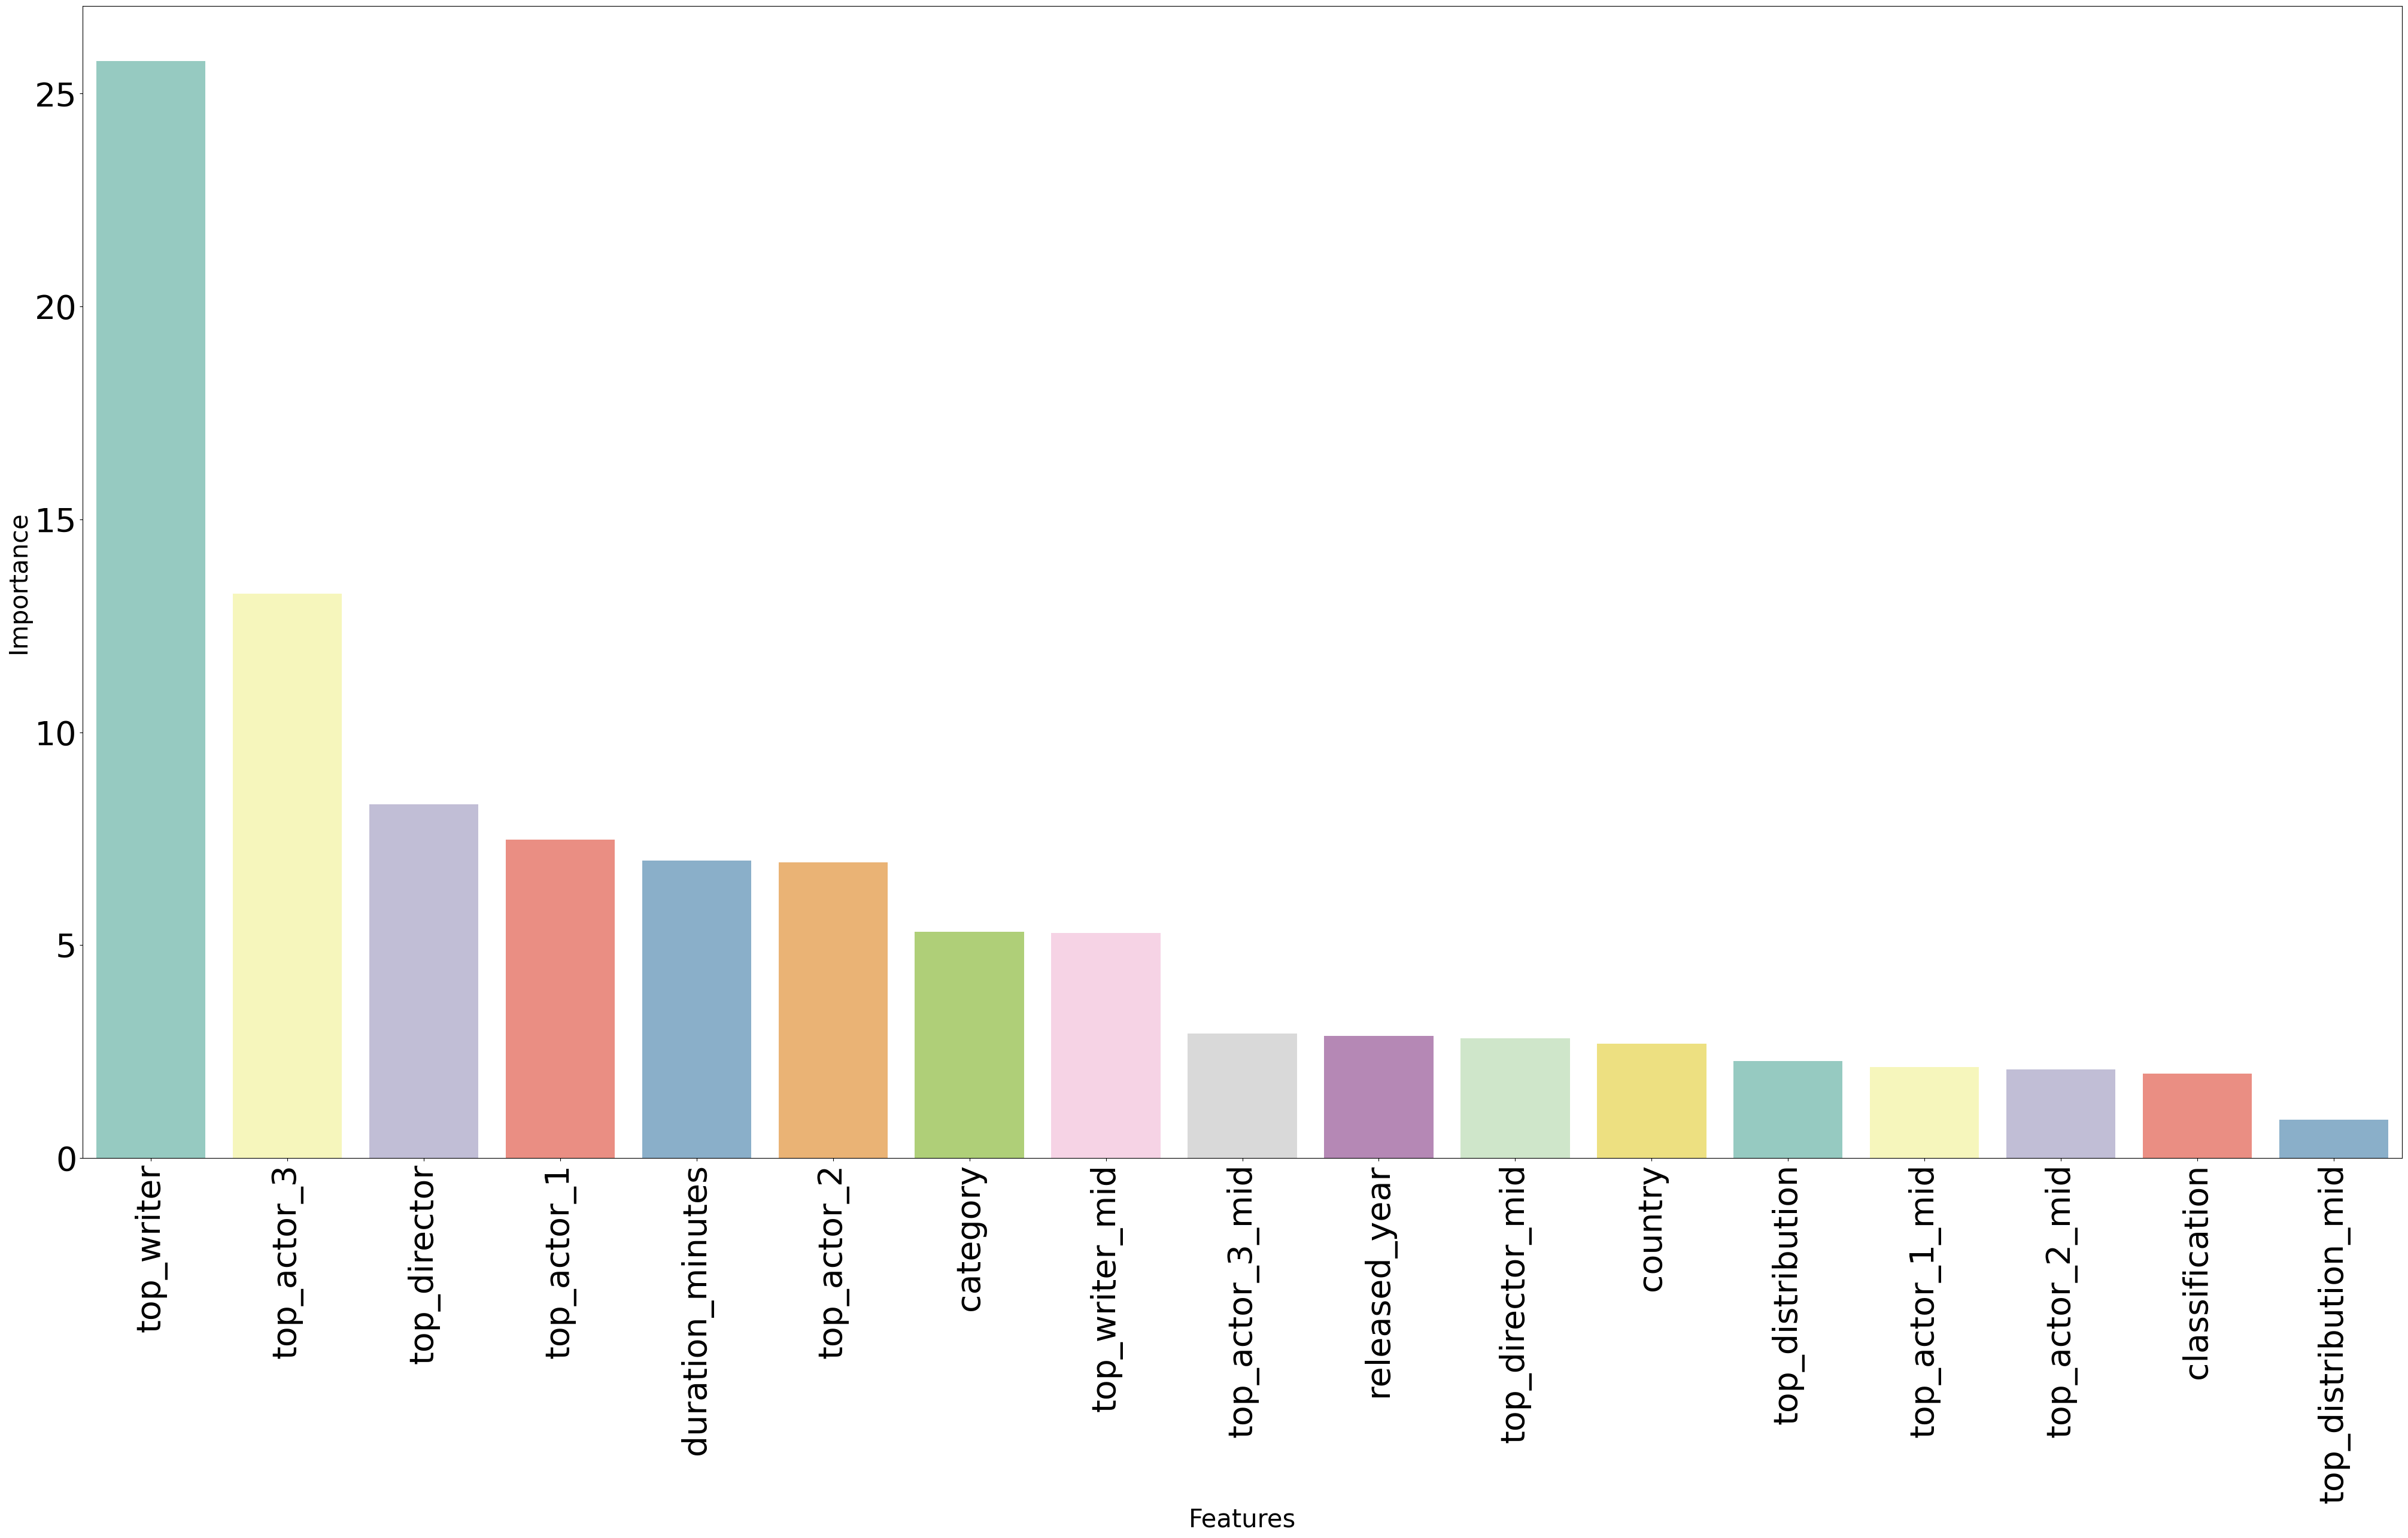

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 25))
sns.barplot(data=feat_imp_df.sort_values(by = 'Importance', ascending=False), x="Feature", y="Importance", palette="Set3")

# Labels axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Taille des ticks
plt.tick_params(axis='both', labelsize=40)

# Rotation des labels en x si besoin (sinon tout se chevauche)
plt.xticks(rotation=90)

plt.show()


In [ ]:
df.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [74]:
from scipy.stats import f_oneway
# Exemple de dataframe df_2_anova
df_2_anova = df.copy()



# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':  # On ne veut pas tester 'weekly_entrances' avec lui-même
        # Créer les groupes selon les valeurs de la colonne discrète
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        # Appliquer le test ANOVA
        stat_anova, p_value = f_oneway(*groups)
        
#         # # Si l'ANOVA est significative (p-value < 0.05), on applique Tukey HSD
#         # if p_value < 0.05:
#         #     # Appliquer le test post-hoc Tukey
#         #     tukey_result = pairwise_tukeyhsd(df_2_anova['weekly_entrances'], df_2_anova[column])
#         #     print(f'Post-hoc Tukey HSD pour {column}:\n', tukey_result.summary())
        
        # Afficher les résultats de l'ANOVA
        print(f'Le résultat pour {column}')
        print("Statistique F:", stat_anova)
        print("P-value:", p_value)
        print('')
        print('================================================================================')


Le résultat pour fr_title
Statistique F: 0.41652693718026995
P-value: 0.9812119563987682

Le résultat pour released_year
Statistique F: 2.9749048311426027
P-value: 1.238115635759097e-10

Le résultat pour directors
Statistique F: 1.5050970011166196
P-value: 5.003036662965276e-35

Le résultat pour writer
Statistique F: 1.4075260181823717
P-value: 8.499730665818995e-24

Le résultat pour distribution
Statistique F: 1.8537591589219735
P-value: 2.0056444949755333e-47

Le résultat pour country
Statistique F: 8.190931457293624
P-value: 1.9089757537287267e-78

Le résultat pour budget
Statistique F: 6.059394708134451
P-value: 0.0

Le résultat pour category
Statistique F: 80.04295805884722
P-value: 5.5e-321

Le résultat pour released_date
Statistique F: 1.0304036874940778
P-value: 0.22050756662100437

Le résultat pour classification
Statistique F: 44.530970788712395
P-value: 8.94625648115363e-54

Le résultat pour duration
Statistique F: 6.1697091752479984
P-value: 9.214400333780716e-108

Le résul

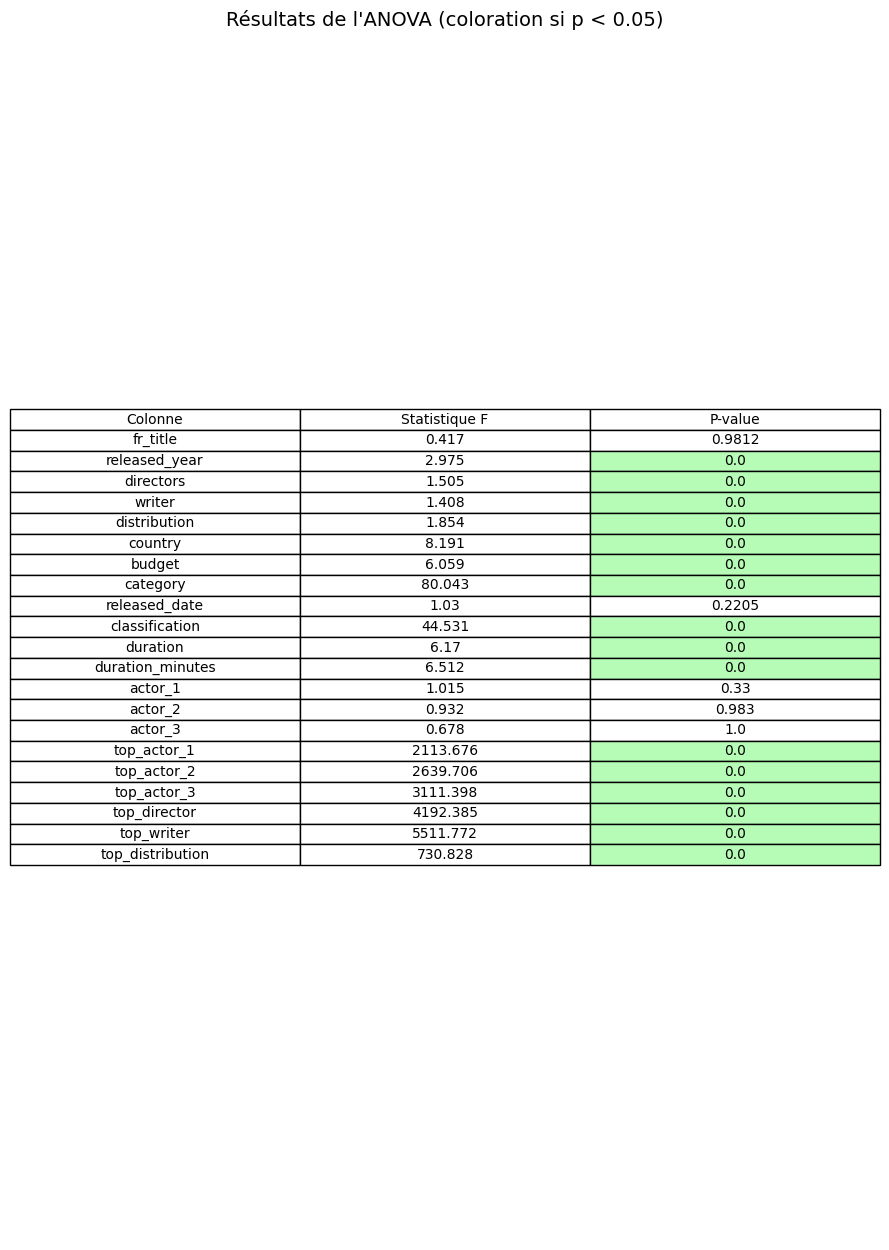

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Exemple de dataframe df_2_anova
df_2_anova = df.copy()

# Liste pour stocker les résultats
results = []

# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        stat_anova, p_value = f_oneway(*groups)
        results.append([column, round(stat_anova, 3), round(p_value, 4)])  # arrondi pour lisibilité

# Créer DataFrame
results_df = pd.DataFrame(results, columns=['Colonne', 'Statistique F', 'P-value'])

# Création du tableau matplotlib
fig, ax = plt.subplots(figsize=(9, len(results_df)*0.6))
ax.axis('off')
ax.axis('tight')

# Création du tableau
table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Appliquer une couleur conditionnelle si p-value < 0.05
for i in range(len(results_df)):
    p_val = results_df.loc[i, 'P-value']
    if p_val < 0.05:
        # Colorier la cellule de la p-value en vert pâle
        table[(i+1, 2)].set_facecolor('#b6fcb6')  # Vert pâle

# Titre
plt.title('Résultats de l\'ANOVA (coloration si p < 0.05)', fontsize=14)
plt.tight_layout()
plt.show()


In [92]:
# 2. Grille de paramètres à tester (tu peux en ajouter)

param_grid = {
    'catboostregressor__depth': [4, 6, 8, 10],
    'catboostregressor__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'catboostregressor__iterations': [200, 300, 500, 700],
    'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 9],
    'catboostregressor__bagging_temperature': [0.0, 0.5, 1.0],
}


# 3. GridSearchCV
grid_search = GridSearchCV(
    catboost_model,
    param_grid,
    cv=3,  # ou 5 pour une validation croisée plus robuste
    scoring='neg_root_mean_squared_error',  # on veut minimiser le RMSE
    n_jobs=4,
    verbose=2
)

# 4. Entraînement
grid_search.fit(X_train, y_train)

# 5. Résultats
print("✅ Best params:", grid_search.best_params_)
print(f"✅ Best RMSE: {-grid_search.best_score_:.4f}")

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
0:	learn: 333560.0313811	total: 3.45ms	remaining: 1.03s
1:	learn: 319745.9804753	total: 7.01ms	remaining: 1.04s
2:	learn: 307804.1411079	total: 10ms	remaining: 990ms
3:	learn: 295962.6213886	total: 13ms	remaining: 962ms
4:	learn: 285795.8798651	total: 16ms	remaining: 942ms
5:	learn: 276948.6152209	total: 19.7ms	remaining: 965ms
6:	learn: 268078.1233068	total: 23ms	remaining: 961ms
7:	learn: 260151.5942297	total: 26ms	remaining: 948ms
8:	learn: 253188.3678291	total: 28.9ms	remaining: 933ms
9:	learn: 246695.2688672	total: 31.8ms	remaining: 921ms
10:	learn: 240335.5624041	total: 35.2ms	remaining: 924ms
11:	learn: 234554.4234875	total: 38.2ms	remaining: 916ms
12:	learn: 229693.4071692	total: 41.1ms	remaining: 907ms
13:	learn: 225309.7261064	total: 44.2ms	remaining: 902ms
14:	learn: 221289.0517380	total: 47.3ms	remaining: 899ms
15:	learn: 217042.0772369	total: 50.6ms	remaining: 898ms
16:	learn: 213956.8366933	total: 54.2ms	rem

In [ ]:
data.columns

Index(['released_year', 'country', 'budget', 'category', 'classification',
       'duration_minutes', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [ ]:
data.classification.unique()

array(['Tout public', 'Interdit - 10 ans', 'Interdit - 6 ans',
       'Interdit - 8 ans', 'Interdit - 12 ans', 'Interdit - 16 ans',
       'Interdit - 18 ans'], dtype=object)

In [ ]:
data.category.unique()

array(['Comédie', 'Science Fiction', 'Comicbook', 'Fantasy',
       'Aventure - Action', 'Guerre', 'Animation', 'Drame', 'Western',
       'Comédie dramatique', 'Thriller', 'Péplum', 'Musical',
       'Film familial', 'Romance', 'Horreur', 'Documentaire',
       'Catastrophe', 'X - Erotique', 'Adaptation Livre', 'Court-métrage',
       'Parodie', 'Action'], dtype=object)

In [ ]:
df_1.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3'],
      dtype='object')

In [ ]:
import pandas as pd

# Exemple : colonnes que ton modèle attend (à adapter si besoin)
columns = [
    df_1.columns
]

# Créer un DataFrame vide avec les bonnes colonnes
df_template_test = pd.DataFrame(columns=columns)



# Ajouter un exemple de ligne (ou plusieurs)
df_1_test_film = pd.DataFrame({['fr_title' : "sinners",
                                'released_year': 2025,
                                'directors':"Ryan Coogler", 
                                'writer':"Ryan Coogler", 
                                'distribution':'Universal Pictures International France',
                                'country':'Etats-Unis',
                                 'budget': 90000000,
                                  'category':'Aventure - Action', 
                                  'released_date':"16/04/2025", 
                                  'classification':'Interdit - 12 ans',                               
                                'duration':"2h 17min", 
                                'weekly_entrances': "", 
                                'duration_minutes':137, 
                                'actor_1': "Michael B. Jordan",
                                'actor_2': "Hailee Steinfeld", 
                                'actor_3':"Miles Caton"]
})

# pred_test = catboost_model.predict(df_test)
# print("Prédiction :", round(pred_test[0]))



SyntaxError: invalid syntax (1302379671.py, line 14)